In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import mysql.connector
import os

In [2]:
conn=mysql.connector.connect(
    host="localhost",
    user="root",
    password="admin",
    database="ecommerce"
)


cursor=conn.cursor()

## Basic Queries

### 1. List all unique cities where customers are located.

In [3]:
query = """select distinct customer_city from customers"""

cursor.execute(query)

data=cursor.fetchall()

data
df=pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


### 2. Count the number of orders placed in 2017.

In [4]:
query="""select count(order_id) from orders where year(order_purchase_timestamp) = 2017;"""
cursor.execute(query)
data = cursor.fetchall()

data[0][0]

45101

### 3. Find the total sales per category.

In [5]:
query="""select products.product_category category, 
round(sum(payments.payment_value),2) sales
from products join order_items
ON products.product_id = order_items.product_id
join payments
ON payments.order_id=order_items.order_id
group by category;"""
cursor.execute(query)
data = cursor.fetchall()

data

df=pd.DataFrame(data, columns=["Category","Sales"])
df.head()

,Category,Sales
0,perfumery,506738.66
1,Furniture Decoration,1430176.39
2,telephony,486882.05
3,bed table bath,1712553.67
4,automotive,852294.33


In [6]:
df=pd.DataFrame(data, columns = ["Category","Sales"])

In [7]:
df
vdf=df.head(10)
vdf
vdf.sort_values(by="Sales",ascending=False,inplace=True)

C:\Users\awana\AppData\Local\Temp\ipykernel_11368\648148921.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vdf.sort_values(by="Sales",ascending=False,inplace=True)


C:\Users\awana\AppData\Local\Temp\ipykernel_11368\1960853788.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


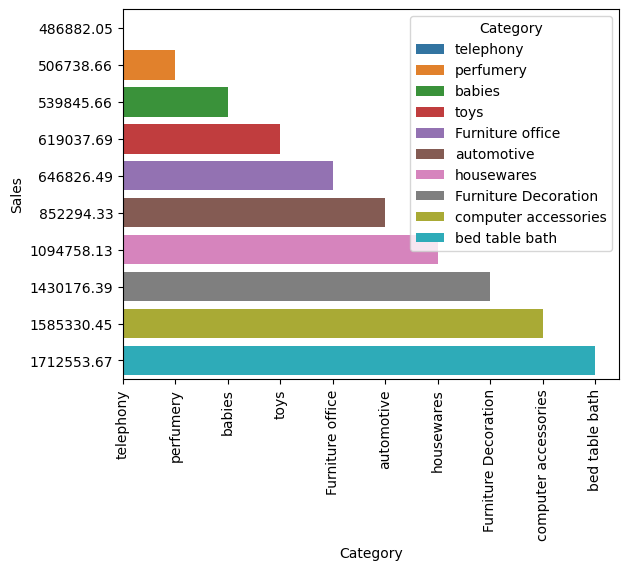

In [8]:
ax=sns.barplot(data=vdf, x="Category", y="Sales" ,hue="Category",orient = 'h')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

### 4. Calculate the percentage of orders that were paid in installments.

In [9]:
query="""select ((sum(
case 
when payment_installments >=1 then 1
else
0
end))/count(*))*100 from payments;"""
cursor.execute(query)
data = cursor.fetchall()

data[0][0]

Decimal('99.9981')

### 5. Count the number of customers from each state.

In [10]:
query="""select customer_state,
count(customer_id) 
from customers 
group by customer_state;"""
cursor.execute(query)
data = cursor.fetchall()

In [11]:
df= pd.DataFrame(data, columns=["States","Customer_Count"])
df.sort_values(by="Customer_Count",ascending=False,inplace=True)
df.head()

,States,Customer_Count
0,SP,41746
4,RJ,12852
2,MG,11635
5,RS,5466
3,PR,5045


C:\Users\awana\AppData\Local\Temp\ipykernel_11368\700150162.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=90)


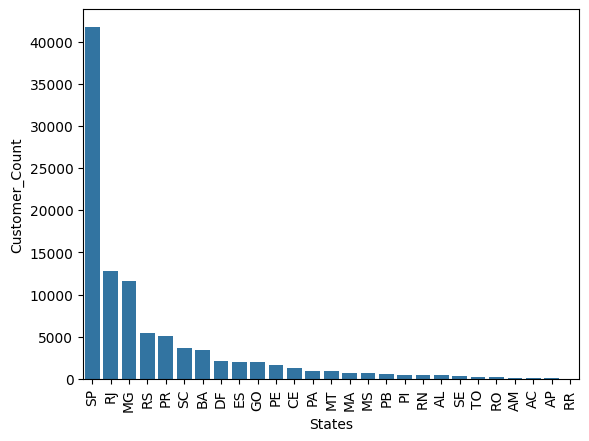

In [12]:
ax=sns.barplot(data=df,x="States",y="Customer_Count")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

## Intermediate Queries

### 1. Calculate the number of orders per month in 2018.

In [13]:
query="""select monthname(order_purchase_timestamp) months,
count(order_id) order_count 
from orders 
where year(order_purchase_timestamp)=2018
group by months;"""
cursor.execute(query)
data = cursor.fetchall()

df=pd.DataFrame(data,columns=["Months","Orders"])
df.head()

,Months,Orders
0,July,6292
1,August,6512
2,February,6728
3,June,6167
4,March,7211


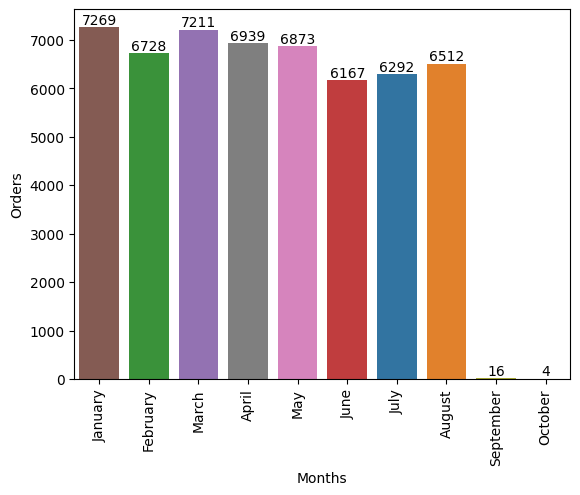

In [14]:
o=['January','February','March','April','May','June','July','August','September','October']
ax=sns.barplot(data=df,x="Months",y="Orders",order=o,hue="Months")
plt.xticks(rotation=90)
for bars in ax.containers:
    ax.bar_label(bars)
plt.show()


### 2. Find the average number of products per order, grouped by customer city.

In [15]:
query="""with count_per_order as 
(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc;"""
cursor.execute(query)
data = cursor.fetchall()
data
df=pd.DataFrame(data, columns=["City","Avarage_Order"])
df.head()

,City,Avarage_Order
0,padre carvalho,7.00
1,celso ramos,6.50
2,candido godoi,6.00
3,datas,6.00
4,matias olimpio,5.00


### 3. Calculate the percentage of total revenue contributed by each product category.

In [16]:
query="""select products.product_category category, 
round((sum(payment_value)/(select sum(payment_value) from payments))*100,2) sales
from products join order_items
ON products.product_id = order_items.product_id
join payments
ON payments.order_id=order_items.order_id
group by category order by sales desc;"""
cursor.execute(query)
data = cursor.fetchall()

data

df=pd.DataFrame(data, columns=["Category","Sales"])
df.head()

,Category,Sales
0,bed table bath,10.70
1,HEALTH BEAUTY,10.35
2,computer accessories,9.90
3,Furniture Decoration,8.93
4,Watches present,8.93


### 4. Identify the correlation between product price and the number of times a product has been purchased.

In [17]:
query="""select products.product_category,
count(order_items.product_id), round(avg(order_items.price),2)
from products join order_items
ON products.product_id = order_items.product_id
group by product_category;"""
cursor.execute(query)
data = cursor.fetchall()

data

df=pd.DataFrame(data, columns=["Category","Orders","Price"])

arr1=df["Orders"]
arr2=df["Price"]

corr=np.corrcoef([arr1,arr2])
print(f"The correlation is:{corr[0][1]}")

The correlation is:-0.10631514167157562


### 5. Calculate the total revenue generated by each seller, and rank them by revenue.

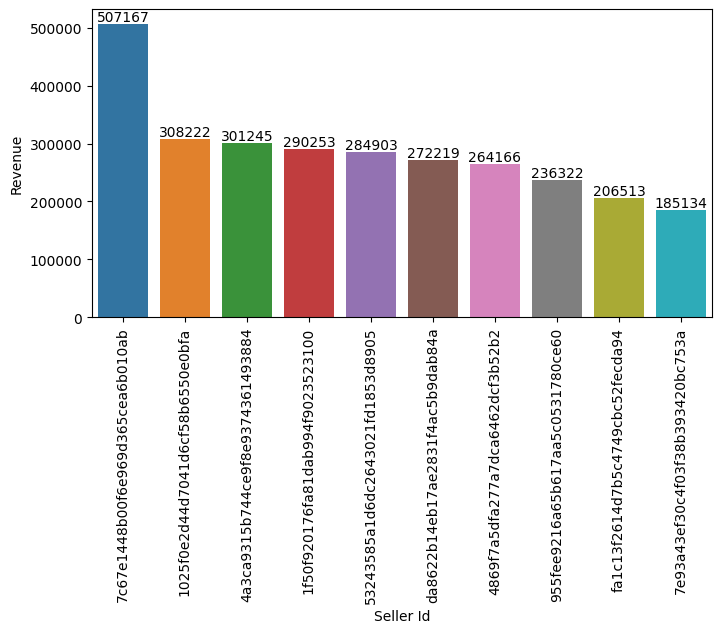

In [18]:
query="""select * , dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id,sum(payments.payment_value) revenue
from order_items join payments
on order_items.order_id=payments.order_id
group by order_items.seller_id) as seller_t;"""
cursor.execute(query)
data = cursor.fetchall()

data
plt.figure(figsize=(8,4))
df=pd.DataFrame(data, columns=["Seller Id","Revenue","Rank"])
bdf=df.head(10)
ax=sns.barplot(data=bdf,x="Seller Id",y="Revenue",hue="Seller Id")
for bars in ax.containers:
    ax.bar_label(bars)
plt.xticks(rotation=90)
plt.show()

## Advanced Queries

### 1. Calculate the moving average of order values for each customer over their order history.

In [19]:
query="""select customer_id, order_purchase_timestamp,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp,
payments.payment_value as payment
from payments join orders
on payments.order_id =orders.order_id)as a;"""
cursor.execute(query)
data = cursor.fetchall()

data

df = pd.DataFrame(data, columns= ['Customer Is','Timestamp','Moving Avarage'])
df.head()

,Customer Is,Timestamp,Moving Avarage
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.010002


### 2. Calculate the cumulative sales per month for each year.

In [20]:
query="""select years,months,payment,sum(payment)
over(order by years,months) Cum_Sales from
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as Months,
round(sum(payments.payment_value),2) as payment from orders join payments
ON orders.order_id = payments.order_id
group by years,months
order by years,Months) as a;"""
cursor.execute(query)
data = cursor.fetchall()

data

df = pd.DataFrame(data, columns= ['Year','Months','Payment','Cum_Sales'])
vdf=df.head(10)

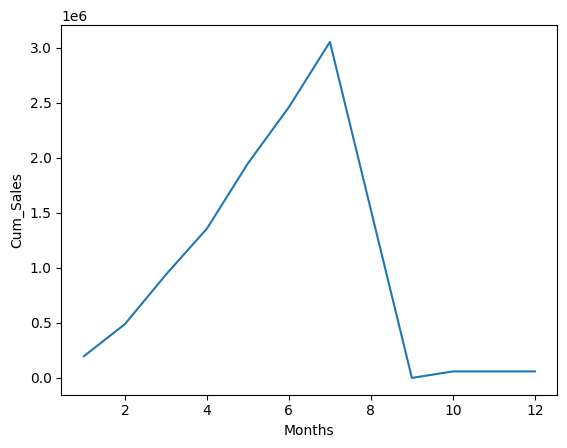

In [21]:
ax=sns.lineplot(data=vdf,x='Months',y='Cum_Sales')

### 3. Calculate the year-over-year growth rate of total sales.

In [22]:
query="""with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
ON orders.order_id = payments.order_id
group by years
order by years)
select years,((payment - lag(payment,1) over(order by years))/
lag(payment - 1) over(order by years))*100 from a ;"""
cursor.execute(query)
data = cursor.fetchall()

data

df = pd.DataFrame(data, columns= ['Year','YPY_Growth'])
df

,Year,YPY_Growth
0,2016,NaN
1,2017,12112.907812
2,2018,20.000927


### 4. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [25]:
query = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id ;"""

cursor.execute(query)
data = cursor.fetchall()

data

[(None,)]

#### since there is no repeted customer so the value is null

### 5. Identify the top 3 customers who spent the most money in each year.

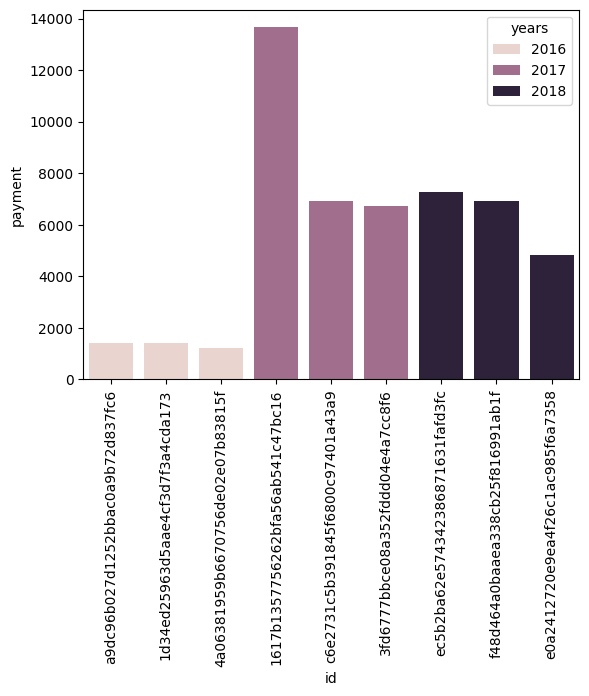

In [27]:
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()